# Radio meteor trajectory estimator 

## Prerequisities

To run this Jupyter Octave notebook, you need working installation of Octave and required libraries.

    sudo apt-get install octave octave-common octave-control octave-general octave-optim octave-signal octave-struct libhdf5-mpich-dev libhdf5-openmpi-dev

It seems to be better install the octave packages directly by Octave packaging system. Ubuntu repository packages does not work correctly in Ubuntu 16.04. 


## Usage 


## Credits

The source code is based on original work of Miguel A. Vallejo, EA4EOZ published at: http://ea4eoz.blogspot.cz/2016/04/determining-radiant-of-meteor-using_10.html


In [1]:
% Observers coordinates in degrees and kilometers above sea level
global Obs = [
 5.51 47.34 0.28 % TX Coordinates (Graves)
 1.00 41.12 0.10 % RX #1 Coordinates (EB3FRN)
-3.75 40.33 0.65 % RX #2 Coordinates (EA4EOZ)
-4.70 41.54 0.72 % RX #3 Coordinates (EA1FAQ)
];

% Solver Boundaries: Lon   Lat   ASL    Ra  Dec   V
global LowerBound = [1.5; 44.60; 100; -360; -90; 12];
global UpperBound = [8.5; 47.34; 120;  720;  90; 72];


In [ ]:
% Observers coordinates in degrees and kilometers above sea level
global Obs = [
 5.51 47.34 0.28 % TX Coordinates (Graves)
 1.00 41.12 0.10 % RX #1 Coordinates (EB3FRN)
-3.75 40.33 0.65 % RX #2 Coordinates (EA4EOZ)
-4.70 41.54 0.72 % RX #3 Coordinates (EA1FAQ)
];

% Solver Boundaries: Lon   Lat   ASL    Ra  Dec   V
global LowerBound = [1.5; 44.60; 100; -360; -90; 12];
global UpperBound = [8.5; 47.34; 120;  720;  90; 72];

In [2]:
pkg load all
warning ("off");
format short g;
global Datetime Doppler tstart Obs_lla;

%
% Degrees to radians
%
function r = deg2rad(d)
    r = d * pi / 180;
endfunction;

%
% Radians to degrees
%
function d = rad2deg(r)
    d = r * 180 / pi;
endfunction;

%
% Converts [lon lat asl] to [x y z]
%
function xyz = lla2xyz(lla)
    lon = lla(1);
    lat = lla(2);
    alt = lla(3) * 1000;
    a = 6378137;
    ee = 8.1819190842622e-2;
    asq = a * a;
    esq = ee * ee;
    N = a / sqrt(1 - esq * sin(lat) ^ 2);
    x = (N + alt) * cos(lat) * cos(lon) / 1000;
    y = (N + alt) * cos(lat) * sin(lon) / 1000;
    z = ((1 - esq) * N + alt) * sin(lat) / 1000;
    xyz = [x y z];
endfunction;

%
% Converts [x y z] to [lon lat asl]
%
function lla = xyz2lla(xyz)
    x = xyz(1) * 1000;
    y = xyz(2) * 1000;
    z = xyz(3) * 1000;
    a = 6378137;
    ee = 8.1819190842622e-2;
    asq = a * a;
    esq = ee * ee;
    b = sqrt(asq * (1 - esq));
    bsq = b * b;
    ep = sqrt((asq - bsq) / bsq);
    p = sqrt(x * x + y * y);
    th = atan2(a * z, b * p);
    lon = atan2(y, x);
    lat = atan2(z + (ep ^ 2) * b * (sin(th) ^ 3), (p - esq * a * (cos(th) ^ 3)));
    N = a / (sqrt(1 - esq * sin(lat) ^ 2));
    alt = (p / cos(lat) - N) / 1000;
    lla = [lon lat alt];
endfunction;

%
% Converts [Ra Dec Vel] velocity vector to [x y z] vector
%
function xyz = rdv2xyz(rdv)
    global GST;
    ra = rdv(1) - GST;
    dec = rdv(2);
    vel = rdv(3);
    x = - vel * cos(dec) * cos(ra);
    y = - vel * cos(dec) * sin(ra);
    z = - vel * sin(dec);
    xyz = [x y z];
endfunction;

%
% Converts [x y z] velocity vector to [Ra Dec Vel] vector
%
function rdv = xyz2rdv(xyz)
    global GST;
    v = norm(xyz);
    ra = GST + atan2(- xyz(2), - xyz(1));
    while (ra >= 2 * pi)
        ra = ra - 2 * pi;
    endwhile;
    while (ra < 0)
        ra = ra + 2 * pi;
    endwhile;
    dec = asin(- xyz(3) / norm(xyz));
    rdv = [ra dec v];
endfunction;

%
% Converts [Ra Dec Vel] into [Az El] from TX site
%
function ae = rdv2txae(rdv)
    global GST Obs_lla;
    txlon = Obs_lla(1, 1); % TX Site
    txlat = Obs_lla(1, 2);
    ra = rdv(1);
    dec = rdv(2);
    ha = GST + txlon - ra;
    sinalt = sin(dec) * sin(txlat) + cos(dec) * cos(txlat) * cos(ha);
    alt = asin(sinalt);
    cosaz = (sin(dec) - sin(alt) * sin(txlat)) / (cos(alt) * cos(txlat));
    az = acos(cosaz);
    if (sin(ha) >= 0)
        az = (2 * pi) - az;
    endif;
    ae = [az alt];
endfunction;

%
% Get sidereal time at Greenwich
%
function st = GreenwichSiderealTime(datetimestring)
    yr = str2num(datetimestring(1:4));
    mn = str2num(datetimestring(5:6));
    dy = str2num(datetimestring(7:8));
    hh = str2num(datetimestring(9:10));
    mm = str2num(datetimestring(11:12));
    ss = str2num(datetimestring(13:14));
    if (mn > 2)
        y = yr;
        m = mn;
    else
        y = yr - 1;
        m = mn + 12;
    endif;
    A = fix(y / 100);
    B = 2 - A + fix(A / 4);
    jd = fix(365.25 * y) + fix(30.6001 * (m + 1)) + dy + 1720994.5 + B;
    T = (jd - 2415020) / 36525;
    st = (0.276919398 + 100.0021359 * T + 0.000001075 * T * T);
    st = st + (((hh / 24) + (mm / 1440) + (ss / 86400)) * 1.002737908);
    st = deg2rad(360 * (st - fix(st)));
endfunction;

%
% Get angle between vectors
%
function angle = getAngle(a, b)
    angle = atan2(norm(cross(a, b)), dot(a, b));
endfunction;

%
% Get radiant elevation of a meteor (as seen from meteor itself)
%
function a = getMeteorElevation(P, V)
    a = getAngle(P, V) - (pi / 2);
endfunction;

%
% Get elevation of object (Obj) as seen from observer (Obs)
%
function a = getHorizonElevation(Obj, Obs)
    a = (pi / 2) - getAngle(Obs, Obj - Obs);
endfunction;

%
% Angular distance in the sky
%
function r = getAngularDistance(rdv1, rdv2)
    a1 = rdv1(1);
    d1 = rdv1(2);
    a2 = rdv2(1);
    d2 = rdv2(2);
    d = acos(sin(d1) * sin(d2) + cos(d1) * cos(d2) * cos(a1 - a2));
    v = abs(rdv1(3) - rdv2(3));
    r = [d v];
endfunction;

%
% Meteor Doppler function
%
function doppler = getDoppler(m, mv, tx, rx)
    mtx = tx - m;
    mrx = rx - m;
    vtx = dot(mv, mtx) / norm(mtx);
    vrx = dot(mv, mrx) / norm(mrx);
    doppler = (vtx + vrx) * 143050000 / 299792.458;
endfunction

%
% Solver function for fsolve
%
function M = meteorSolver(vector)
    global Obs Doppler;
    vector = vector';
    m = lla2xyz(vector(1:3));
    mv = rdv2xyz(vector(4:6));
    M = Doppler(:, 3);
    for n = 1:rows(M)
        r = Doppler(n, 1);
        time = Doppler(n, 2);
        M(n) = getDoppler(m + mv * time, mv, Obs(1, :), Obs(1 + r, :)) - M(n);
    endfor;
    M = M';
endfunction;


In [3]:

%
% Print data header
%
function printHeader
    global Datetime tstart;
    meteor = num2str(Datetime);
    printf('######################################################################################################\n');
    printf('#\n');
    printf('# Meteor: %s-%s\n', meteor(1:8), meteor(9:14));
    printf('# tstart: %f\n', tstart);
    printf('#\n');
    printf('#  Mx      My      Mz      Vx      Vy      Vz     Lon    Lat     Asl    Ra    Dec    Vel    TXaz   TXel    RMS\n');
    printf('#====== ======= ======= ======= ======= ======= ======= ====== ====== ====== ====== ====== ====== ====== ===========\n');
endfunction;

%
% Print meteor solution
%
function printData(solution)
    for n = 1:rows(solution)
        s = solution(n, :);
        P = s(1:3);
        V = s(4:6);
        rms = s(7);
        % keep Ra in 0:360
        while (V(1) < 0)
            V(1) = V(1) + 2 * pi;
        endwhile;
        while (V(1) >= 2 * pi)
            V(1) = V(1) - 2 * pi;
        endwhile;
        xyze = lla2xyz(P);
        xyzs = rdv2xyz(V);
        ae = rdv2txae([V(1) V(2)]);
        printf('%7.1f ', xyze(1)); % Mx
        printf('%7.1f ', xyze(2)); % My
        printf('%7.1f ', xyze(3)); % Mz
        printf('%7.1f ', xyzs(1)); % Vx
        printf('%7.1f ', xyzs(2)); % Vy
        printf('%7.1f ', xyzs(3)); % Vz
        printf('%7.2f ', rad2deg(P(1))); % Lon
        printf('%6.2f ', rad2deg(P(2))); % Lat
        printf('%6.2f ', P(3)); % ASL
        printf('%6.1f ', rad2deg(V(1))); % Ra
        printf('%6.1f ', rad2deg(V(2))); % Dec
        printf('%6.1f ', V(3)); % Vel
        printf('%6.1f ', rad2deg(ae(1))); % Gaz
        printf('%6.1f ', rad2deg(ae(2))); % Gel
        printf('%11.5f ', rms);
        printf('\n');
    endfor;
endfunction;

%
% Create a random meteor as starting point to the solver
%
function meteor = CreateRandomMeteor
    global LowerBound UpperBound;
    lon = LowerBound(1) + rand * (UpperBound(1) - LowerBound(1));
    lat = LowerBound(2) + rand * (UpperBound(2) - LowerBound(2));
    asl = LowerBound(3) + rand * (UpperBound(3) - LowerBound(3));
    %ra=LowerBound(4)+rand*(UpperBound(4)-LowerBound(4));
    ra = rand * 2 * pi;
    dec = LowerBound(5) + rand * (UpperBound(5) - LowerBound(5));
    v = LowerBound(6) + rand * (UpperBound(6) - LowerBound(6));
    meteor = [lon lat asl ra dec v];
endfunction;

%
% Check if a meteor is visible (and possible)
%
function vis = isVisible(meteor)
    global Obs;
    vis = false;
    P = lla2xyz(meteor(1:3));
    V = rdv2xyz(meteor(4:6));
    if getMeteorElevation(P, V) >= 0 % Falling meteor
        %if getHorizonElevation(P,Obs(1,:)) >= 0        % Elevation from TX
        if getHorizonElevation(P, Obs(2, :)) >= 0 % Elevation from RX1
            if getHorizonElevation(P, Obs(3, :)) >= 0 % Elevation from RX2
                if getHorizonElevation(P, Obs(4, :)) >= 0 % Elevation from RX3
                    vis = true;
                endif;
            endif;
        endif;
        %endif;
    endif;
endfunction;

%
% Load a obs file into Datetime and Doppler matrix
%
function ReadDataFile(dataFile)
    global Datetime Doppler tstart;
    tstart = 1000;
    fid = fopen(dataFile);
    while (!feof(fid))
        line = fgetl(fid);
        if strncmp(line, '#F', 2)
            Datetime = strtrim([line(4:11) line(13:18)]);
        endif;
        if ((strncmp(line, '1', 1)) || (strncmp(line, '2', 1)) || (strncmp(line, '3', 1)))
            data = strread(line);
            R(end + 1, :) = data(1);
            T(end + 1, :) = data(2);
            if (data(2) < tstart)
                tstart = data(2);
            endif;
            D(end + 1, :) = data(3);
        endif;
    endwhile;
    fclose(fid);
    T = T - tstart;
    Doppler = [R T D];
endfunction;

In [4]:


ReadDataFile("20151119-021356_clean.obs");

% Greenwich Sidereal Time
global GST = GreenwichSiderealTime(Datetime);

% Observer's coordinates to radian ones
for n = 1:rows(Obs)
    Obs_lla(n, :) = [deg2rad(Obs(n, 1)) deg2rad(Obs(n, 2)) Obs(n, 3)];
endfor;

% Observer's coordinates to rectangular ones
for n = 1:rows(Obs)
    Obs(n, :) = lla2xyz(Obs_lla(n, :));
endfor;

% Bounds in radians
LowerBound = [deg2rad(LowerBound(1)); deg2rad(LowerBound(2)); LowerBound(3); deg2rad(LowerBound(4)); deg2rad(LowerBound(5)); LowerBound(6)];
UpperBound = [deg2rad(UpperBound(1)); deg2rad(UpperBound(2)); UpperBound(3); deg2rad(UpperBound(4)); deg2rad(UpperBound(5)); UpperBound(6)];

% Header
printHeader;
attempts = 0;
solutions = 0;
minrms = 1e10;

do
    do
%        try
            meteor = CreateRandomMeteor;
            [k, fval, cvg, outp] = nonlin_residmin("meteorSolver", meteor',options('MaxIter',1000,"lbound", LowerBound, "ubound", UpperBound));
            success = 1;
%        catch
%            success = 0;
%        end_try_catch;
    until (success == 1);
    
    k = k';
    fval = fval';
    attempts = attempts + 1;
    if isVisible(k)
        rms = norm(fval) / sqrt(rows(fval));
        printData([k rms]);
        solutions = solutions + 1;
        if (rms < minrms)
            minrms = rms;
            bestfval = fval;
            bestkval = k;
        endif
    endif;
until (solutions == 10);

printf('#\n');
printf('# RMS: %10.5f\n', minrms);
printf('#\n');
curv = [Doppler bestfval];
for n = 1:rows(curv)
    printf('# %d %5.3f %8.3f %8.3f %8.3f\n', curv(n, 1), curv(n, 2), curv(n, 3), curv(n, 4), curv(n, 3) + curv(n, 4));
endfor;
printf('#\n');
printf('# Hardness: %d\n', attempts);
printf('#\n');

######################################################################################################
#
# Meteor: 20151119-021356
# tstart: 4.640125
#
#  Mx      My      Mz      Vx      Vy      Vz     Lon    Lat     Asl    Ra    Dec    Vel    TXaz   TXel    RMS
#====== ======= ======= ======= ======= ======= ======= ====== ====== ====== ====== ====== ====== ====== ===========
 4396.7   439.4  4748.9   -21.8    10.7    -2.6    5.71  47.25 120.00   65.1    6.1   24.4  223.5   40.7     5.77462 
 4390.2   431.4  4755.6   -21.7    10.4    -2.6    5.61  47.34 120.00   65.7    6.2   24.3  222.9   41.0     5.88605 
 4462.1   519.0  4679.8   -23.5    11.1    -6.8    6.63  46.36 120.00   66.1   14.7   26.9  228.4   48.6     5.37649 
 4390.2   431.4  4755.6   -21.7    10.4    -2.6    5.61  47.34 120.00   65.7    6.2   24.3  222.9   41.0     5.88603 
 4447.5   337.5  4695.5     0.0     0.0   -12.3    4.34  46.66 109.40    0.0   90.0   12.3  360.0   47.3  4578.95490 
 4461.7   518.5  4680.3   -23.

In [14]:
CreateRandomMeteor

ans =

    0.074704      0.7845      105.04      1.6748      1.5424      67.252



In [12]:
[Doppler bestfval]

ans =

           1           0      465.64      2.4542
           1       0.016      439.01      1.0599
           1       0.032      414.04     -2.0577
           1       0.048       383.4     0.41341
           1       0.064      358.44     -2.8579
           1        0.08      324.79      2.4953
           1       0.096      301.89      -2.982
           1       0.112      269.49      0.9761
           1       0.128      239.58      2.3635
           1       0.144      205.21      8.1552
           1        0.16      177.21      7.4981
           1       0.176      152.54      3.4382
           1       0.192      130.79     -3.6177
           1       0.208      100.82     -2.5134
           1       0.224      72.083     -2.7172
           1        0.24      53.575     -13.221
           1       0.256      11.129     0.14209
           2           0      84.557     0.43464
           2       0.016      64.075     -5.1394
           2       0.032      41.569     -8.7621
           2 

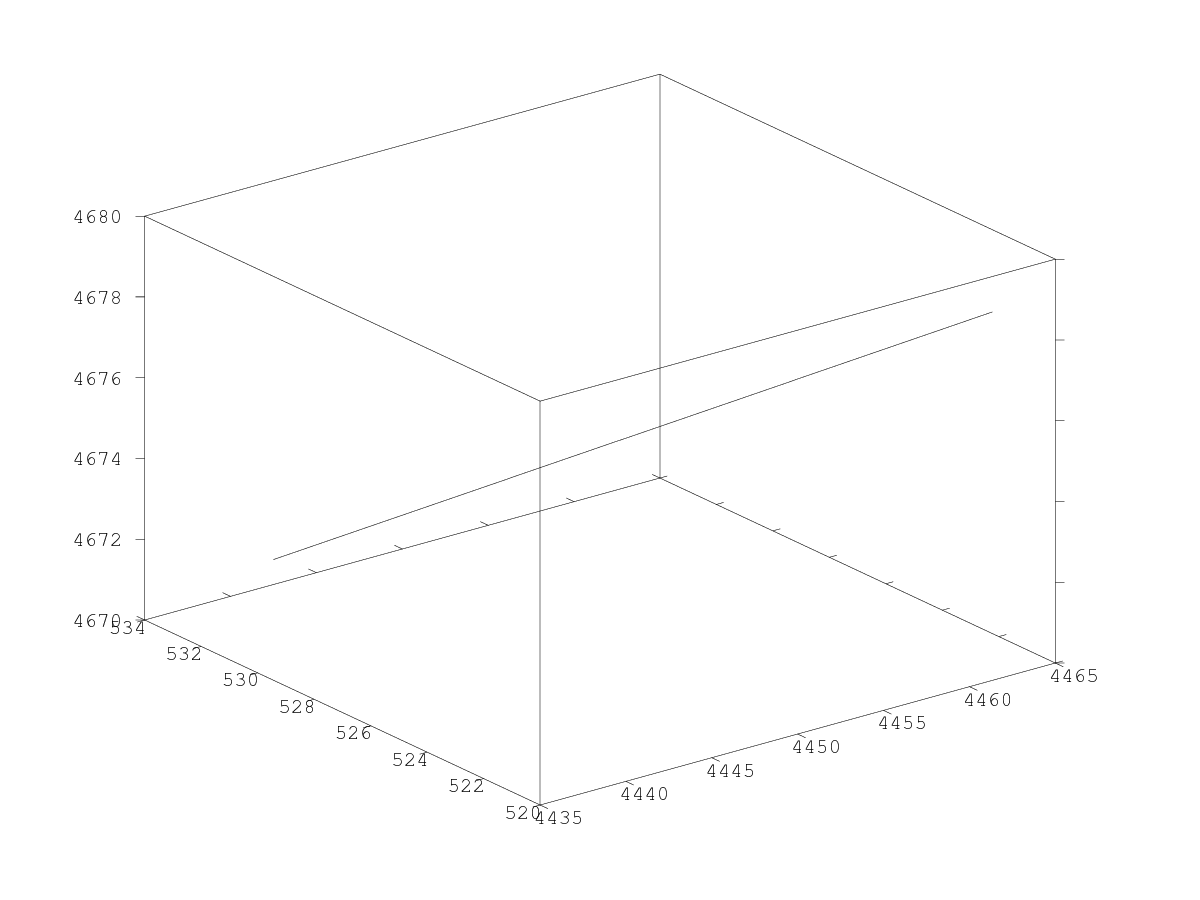

In [8]:
x = linspace (4463.3,  4463.3 - 23.6);
y = linspace (521.2,  521.2 + 11.1);
z = linspace (4678.5, 4678.5 - 7.0 );
plot3 (x, y, z);

In [ ]:
met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[meteor]))


In [7]:
tstep = 0.2


tstep =        0.2


In [ ]:
20151119-021356

#  Px     Py      Pz      Vx    Vy     Vz   Lon    Lat     Asl    Ra    Dec    Vel      RMS
#====== ====== ======= ====== =====  ===== ===== ======  ====== ====== ====== ===== ===========
 4450.6  507.4  4692.0  -23.2  11.2   -6.0  6.50  46.52  120.00   65.5   13.1  26.4     5.35833 
